# Import libraries

In [1]:
# General libraries
import numpy as np
from pyDOE import lhs

# Parallelisation libraries
from joblib import Parallel, delayed

# Module functions
import ximinf.selection_effects as se
import ximinf.generate_sim as gsim

# Plot libraries
import matplotlib.pyplot as plt

# Generation of SN Ia samples in parallel

In [2]:
# -------- User parameters --------

N = 10 # Number of samples 100_000
M = 15_000 # Number of SNe per sample

# Range of standardisation paremeters
alpha_range = (-0.3, 0) # TO CHANGE FOR TWO PARAMS FOR BROKEN ALPHA #(-0.6, 0.4)
beta_range  = (2.5, 3.5) #(2.8, 3.8)
mabs_range = (-19.8, -18.8) #(-19.8, -18.8)

# ---------------------------------

# Sampling
unit_samples = lhs(3, samples=N) #(3, samples=N)
alpha_vals = unit_samples[:, 0] * (alpha_range[1] - alpha_range[0]) + alpha_range[0]
beta_vals  = unit_samples[:, 1] * (beta_range[1]  - beta_range[0])  + beta_range[0]
mabs_vals  = unit_samples[:, 2] * (mabs_range[1]  - mabs_range[0])  + mabs_range[0]

columns = ['magobs', 'magobs_err','x1', 'x1_err', 'c', 'c_err','z']

# Parallel execution
print("Launching parallel simulations...")
results = Parallel(n_jobs=6)(
    delayed(gsim.simulate_one)(alpha_, beta_, mabs_, sigma_int=0.15, z_max=0.2, M=M, 
                               cols = columns, N=N, i=i) for i, (alpha_, beta_, mabs_) in enumerate(zip(alpha_vals, beta_vals, mabs_vals))
)
print("... simulations done")

# Collect results without a loop
simulations = np.vstack(results).astype(np.float32)

# Applying selection effect
print('Applying selection effect...')
m_lim = 19.5
simulations = se.malmquist_bias_batch(simulations, m_lim, M, len(columns))
print('...done')

Launching parallel simulations...
... simulations doneation 1/10
Applying selection effect...
...done


# Plot the first sample

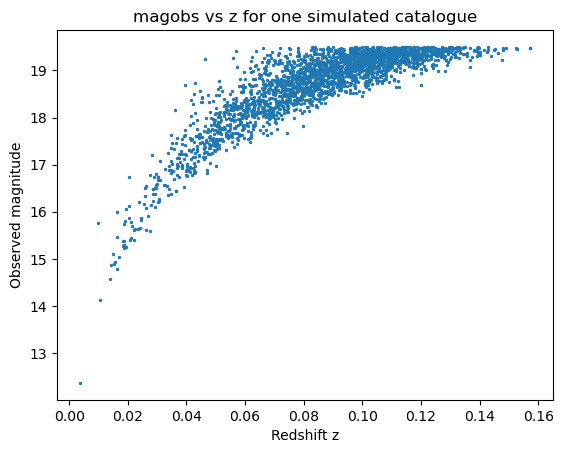

Number of SNe after selection: 2535


In [6]:
example = simulations[0]
_, df_ex = gsim.unflatten_array(example, columns, M)
df_ex_cut = df_ex[df_ex['magobs'] > 0]

plt.figure()
plt.scatter(df_ex_cut['z'], df_ex_cut['magobs'], s=2)
plt.xlabel("Redshift z")
plt.ylabel("Observed magnitude")
plt.title("magobs vs z for one simulated catalogue")
plt.show()

print('Number of SNe after selection:', len(df_ex_cut['magobs']))

# Save data to disk

In [9]:
print("Save results ...")
np.save("../data/SIM/simulations.npy", simulations)
size_bytes = N * (4*M+3) * np.dtype(simulations.dtype).itemsize
size_MB = size_bytes / (1024**2)
print(f"... saved {size_MB:.2f} MB to 'simulations.npy'")

Save results ...
... saved 153.73 MB to 'simulations.npy'
